In [5]:
import csv
import os
from PIL import Image
import torch
import random
random.seed(0)

base_dir = 'sample/images'

dataset_list = [os.path.join(base_dir,file) for file in os.listdir(base_dir) if file.endswith('.png')]
dataset_list.sort()
label_list = [label.replace('.png', '.txt').replace('images','labels') for label in dataset_list]
# Combine dataset_list and label_list into a single dataset
combined_dataset = list(zip(dataset_list, label_list))
combined_dataset

[('sample/images/OBJ00022_PS3_K3_NIA0078.png',
  'sample/labels/OBJ00022_PS3_K3_NIA0078.txt'),
 ('sample/images/OBJ00028_PS3_K3_NIA0078.png',
  'sample/labels/OBJ00028_PS3_K3_NIA0078.txt'),
 ('sample/images/OBJ00032_PS3_K3_AIDATA0585.png',
  'sample/labels/OBJ00032_PS3_K3_AIDATA0585.txt'),
 ('sample/images/OBJ00036_PS3_K3_AIDATA0585.png',
  'sample/labels/OBJ00036_PS3_K3_AIDATA0585.txt'),
 ('sample/images/OBJ00059_PS3_K3_AIDATA0587.png',
  'sample/labels/OBJ00059_PS3_K3_AIDATA0587.txt')]

In [1]:
import cv2
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def cluster_and_crop(image_path, k=2, size=1024, crop_num=43, threshold=0.7):
    # 이미지 로드 및 리사이즈
    img = Image.open(image_path)
    img = img.resize((size, size))
    
    # 이미지를 numpy 배열로 변환 (RGB 값 형태)
    img_np = np.array(img)
    
    # 이미지 데이터를 준비 (픽셀 수, 3) 형태로 변형
    img_data = img_np.reshape((-1, 3))
    img_data = np.float32(img_data)

    # K-Means 적용
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(img_data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # 클러스터링 결과를 이미지로 변환
    centers = np.uint8(centers)
    segmented_img = centers[labels.flatten()]
    segmented_img = segmented_img.reshape(img_np.shape)

    # 검은색에 가장 가까운 클러스터 찾기
    black_cluster_index = np.argmin(np.linalg.norm(centers, axis=1))  # 가장 작은 RGB 값이 검은색
    
    # crop 영역 추출
    num_patches = []
    crop_size = segmented_img.shape[1] // crop_num
    for i in range(crop_num):
        for j in range(crop_num):
            
            crop_img = segmented_img[i * crop_size:(i + 1) * crop_size, j * crop_size:(j + 1) * crop_size]

            # 검은색 클러스터 비율 확인
            cluster_0_value = centers[black_cluster_index]
            cluster_0_mask = np.all(crop_img == cluster_0_value, axis=-1)
            if np.mean(cluster_0_mask) > threshold:
                num_patches.append((i, j))

    
    return num_patches

def save_cropped_patches_as_numpy(image_path, 
                                  image_path_cluster,
                                  crop_size, 
                                  resize_size,
                                  cluster_img_size,
                                  cluster_threshold,
                                  save_dir):
    image_name = os.path.basename(image_path)
    print(f"Processing {image_name}")
    image = Image.open(image_path_cluster).convert('RGB')
    
    image_width, image_height = image.size
    
    # num_patches = cluster_and_crop(image_path, 
    #                                k=3, 
    #                                size=cluster_img_size, 
    #                                crop_num=(image_width + crop_size - 1) // crop_size, 
    #                                threshold=cluster_threshold)
    
    num_patches = [(i, j) for i in range((image_width + crop_size - 1) // crop_size) for j in range((image_height + crop_size - 1) // crop_size)]
    
    image = Image.open(image_path)
    for i, j in tqdm(num_patches):
        top_left_x = i * crop_size
        top_left_y = j * crop_size
        bottom_right_x = min(top_left_x + crop_size, image_width)
        bottom_right_y = min(top_left_y + crop_size, image_height)
        
        if bottom_right_x - top_left_x < crop_size:
            top_left_x = max(image_width - crop_size, 0)
            bottom_right_x = image_width
        if bottom_right_y - top_left_y < crop_size:
            top_left_y = max(image_height - crop_size, 0)
            bottom_right_y = image_height
        
        cropped_image = image.crop((top_left_x, top_left_y, bottom_right_x, bottom_right_y))
        
        cropped_image = cropped_image.resize((resize_size, resize_size), resample=Image.Resampling.LANCZOS)
        
        crop_filename = f"{os.path.splitext(image_name)[0]}_{top_left_x}_{top_left_y}.png"
        crop_path = os.path.join(save_dir, crop_filename)
        cropped_image.save(crop_path, format="PNG")

    del image

crop_size = 256
resize_size = 1024
cluster_img_size = 1024
cluster_threshold = 0.0
target_dir = './target_dir'
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

save_cropped_patches_as_numpy(
    "./tasksample.png", "tasksample.png",
                                          crop_size, 
                                          resize_size, 
                                          cluster_img_size,
                                          cluster_threshold,
                                          target_dir)

Processing tasksample.png


/Users/seungwoo/anaconda3/envs/dust/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1849/1849 [08:27<00:00,  3.64it/s]


# 원본

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

# 상대 좌표를 절대 좌표로 변환하는 함수
def convert_to_absolute(coords, img_size):
    h, w = img_size
    abs_coords = [(float(coords[i]) * w, float(coords[i+1]) * h) for i in range(0, len(coords), 2)]
    return abs_coords

def extract_polygons_and_images(image, label_list):
    """라벨 리스트에서 각 폴리곤의 이미지를 추출하는 함수"""
    img_size = image.shape[:2]  # (height, width)
    cropped_images = []
    masks = []
    class_labels = []
    
    for label in label_list:
        label_split = label.strip().split()
        if len(label_split) < 9:
            print(f"잘못된 라벨 형식: {label}")
            continue
        class_label = label_split[0]  # 클래스 라벨 추출
        coords = label_split[1:]  # 좌표 값만 추출
        
        # 절대 좌표로 변환
        obb_coords = convert_to_absolute(coords, img_size)
        polygon = np.array(obb_coords, dtype=np.int32)
    
        # 폴리곤 마스크 생성
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 255)
        cropped_img = cv2.bitwise_and(image, image, mask=mask)
        
        masks.append(mask)
        cropped_images.append(cropped_img)
        class_labels.append(class_label)  # 클래스 라벨 저장
    
    return cropped_images, masks, class_labels

def rotate_polygon(image, mask, angle):
    """이미지와 마스크를 주어진 각도로 회전시키는 함수"""
    (h, w) = mask.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 회전 후 이미지 크기를 모두 포함하도록 조정
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # 회전 변환 행렬에 이동을 추가
    M[0, 2] += (nW / 2) - center[0]
    M[1, 2] += (nH / 2) - center[1]

    rotated_image = cv2.warpAffine(image, M, (nW, nH))
    rotated_mask = cv2.warpAffine(mask, M, (nW, nH), flags=cv2.INTER_NEAREST)

    return rotated_image, rotated_mask

def get_sea_mask(image):
    """그레이스케일 이미지를 사용하여 밝은 영역을 제외한 바다 마스크를 생성하는 함수"""
    # 이미지를 그레이스케일로 변환
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 밝은 영역을 제외하기 위한 임계값 설정
    # 임계값은 이미지의 밝기에 따라 조정이 필요할 수 있습니다.
    threshold_value = 180  # 밝은 영역 기준 임계값 (0~255 사이의 값)
    
    # 임계값을 사용하여 이진화
    _, sea_mask = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY_INV)
    
    # 마스크를 이진 형태로 변환 (0과 1로 구성)
    sea_mask = (sea_mask / 255).astype(np.uint8)
    
    return sea_mask


def select_position_from_mask(sea_positions, target_w, target_h, new_w, new_h, sea_mask):
    max_attempts = 1000
    attempts = 0

    while attempts < max_attempts:
        idx = random.randint(0, len(sea_positions) - 1)
        y, x = sea_positions[idx]
        offset_x = max(0, x - new_w // 2)
        offset_y = max(0, y - new_h // 2)

        # 이미지 경계 내에 위치하는지 확인
        if offset_x + new_w > target_w or offset_y + new_h > target_h:
            attempts += 1
            continue

        # mask_region 추출
        mask_region = sea_mask[offset_y:offset_y + new_h, offset_x:offset_x + new_w]

        if mask_region.shape[0] != new_h or mask_region.shape[1] != new_w:
            attempts += 1
            continue

        if np.all(mask_region == 1):
            return offset_x, offset_y
        else:
            attempts += 1

    return None, None

def resize_and_paste_polygons(cropped_images, masks, class_labels, target_img, sea_mask, scale=0.77/5, rotate_angle_range=(-180, 180)):
    """폴리곤 이미지를 리사이즈하고 바다 영역 내에 배치하는 함수"""
    all_polygons_coords = []
    all_class_labels = []

    # 바다 마스크에서 위치 추출
    sea_positions = np.argwhere(sea_mask == 1)
    target_h, target_w = target_img.shape[:2]

    for cropped_img, mask, class_label in zip(cropped_images, masks, class_labels):
        x, y, w, h = cv2.boundingRect(mask)
        cropped_polygon = cropped_img[y:y+h, x:x+w]
        mask_polygon = mask[y:y+h, x:x+w]

        # 이미지 리사이즈
        new_w = int(w * scale)
        new_h = int(h * scale)

        if new_w <= 1 or new_h <= 1:
            print("리사이즈 후 이미지가 너무 작아 생략합니다.")
            continue

        resized_polygon = cv2.resize(cropped_polygon, (new_w, new_h), interpolation=cv2.INTER_AREA)
        resized_mask = cv2.resize(mask_polygon, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # 무작위 회전 적용
        random_angle = random.uniform(rotate_angle_range[0], rotate_angle_range[1])
        rotated_polygon, rotated_mask = rotate_polygon(resized_polygon, resized_mask, random_angle)

        # 회전 후 이미지 크기 업데이트
        new_h, new_w = rotated_mask.shape[:2]

        # 바다 마스크에서 위치 선택
        offset_x, offset_y = select_position_from_mask(sea_positions, target_w, target_h, new_w, new_h, sea_mask)

        if offset_x is None:
            print("적절한 위치를 찾지 못해 생략합니다.")
            continue

        # 회전된 마스크에서 컨투어 추출
        contours, _ = cv2.findContours(rotated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print("회전된 마스크에서 폴리곤을 찾을 수 없습니다.")
            continue
        cnt = contours[0]

        # 회전된 사각형 구하기
        rot_rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rot_rect)
        box = box.astype(int)

        # 좌표를 타겟 이미지 좌표계로 변환
        box_in_target = box + np.array([offset_x, offset_y])

        all_polygons_coords.append(box_in_target)
        all_class_labels.append(class_label)  # 클래스 라벨 저장

        # 타겟 이미지에 폴리곤 붙여넣기
        region_of_interest = target_img[offset_y:offset_y+new_h, offset_x:offset_x+new_w]
        mask_inv = cv2.bitwise_not(rotated_mask)

        target_bg = cv2.bitwise_and(region_of_interest, region_of_interest, mask=mask_inv)
        polygon_fg = cv2.bitwise_and(rotated_polygon, rotated_polygon, mask=rotated_mask)

        combined = cv2.add(target_bg, polygon_fg)
        target_img[offset_y:offset_y+new_h, offset_x:offset_x+new_w] = combined

    return target_img, all_polygons_coords, all_class_labels

def save_image_and_label(image, label_coords, class_labels, image_num):
    """증강된 이미지와 라벨 파일을 저장하는 함수"""
    image_save_path = f"./dataset3/images/val/augments{image_num}.png"
    label_save_path = f"./dataset3/labels/val/augments{image_num}.txt"

    # 이미지 저장
    cv2.imwrite(image_save_path, image)

    # 이미지 크기
    img_h, img_w = image.shape[:2]

    # 라벨 저장
    with open(label_save_path, 'w') as label_file:
        for polygon, class_label in zip(label_coords, class_labels):
            # 좌표를 (x1, y1, x2, y2, x3, y3, x4, y4) 순서로 정렬
            polygon = polygon.astype(np.float32)
            relative_coords = polygon / [img_w, img_h]
            relative_coords = relative_coords.flatten()
            # 좌표 개수가 8개인지 확인
            if len(relative_coords) != 8:
                print(f"좌표 개수가 8개가 아닙니다: {relative_coords}")
                continue
            coords_str = ' '.join(map(str, relative_coords))
            label_file.write(f"{class_label} {coords_str}\n")

def augment_and_save_images(combined_dataset, target_dir_list, num_samples, num_augments, target_size=(512, 512), scale=0.77/2.5, rotate_angle_range=(-180, 180)):
    os.makedirs("./dataset3/images/", exist_ok=True)
    os.makedirs("./dataset3/labels/", exist_ok=True)

    for augment_num in range(1, num_augments + 1):
        while True:
            # 타겟 이미지 선택 및 초기화
            target_img_path = random.choice(target_dir_list)
            target_img = cv2.imread(target_img_path)
            if target_img is None:
                print(f"타겟 이미지 {target_img_path}를 찾을 수 없습니다.")
                continue

            target_img = cv2.resize(target_img, target_size)

            # 바다 마스크 생성
            sea_mask = get_sea_mask(target_img)

            # 바다 위치 추출
            sea_positions = np.argwhere(sea_mask == 1)
            if len(sea_positions) == 0:
                print(f"타겟 이미지 {target_img_path}에서 바다 영역을 찾을 수 없습니다. 다른 이미지를 선택합니다.")
                continue
            else:
                break

        all_polygons_coords = []
        all_class_labels = []
        
        # 샘플링한 데이터 처리
        sampled_data = random.sample(combined_dataset, num_samples)
        
        for source_img_path, source_label_path in sampled_data:
            # 소스 이미지와 라벨 로드
            try:
                with open(source_label_path, 'r') as f:
                    source_label_list = f.read().strip().split('\n')
                    source_label_list = [label for label in source_label_list if not label.startswith('0')]
            except FileNotFoundError:
                print(f"라벨 파일 {source_label_path}를 찾을 수 없습니다.")
                continue

            source_img = cv2.imread(source_img_path)
            if source_img is None:
                print(f"소스 이미지 {source_img_path}를 찾을 수 없습니다.")
                continue

            # 폴리곤 이미지 및 마스크 추출
            cropped_images, masks, class_labels = extract_polygons_and_images(source_img, source_label_list)

            # 폴리곤을 리사이즈하고 타겟 이미지에 붙여넣기
            target_img, polygon_coords, updated_class_labels = resize_and_paste_polygons(
                cropped_images, masks, class_labels, target_img, sea_mask, scale=scale, rotate_angle_range=rotate_angle_range)
            all_polygons_coords.extend(polygon_coords)
            all_class_labels.extend(updated_class_labels)

        # 증강된 이미지와 라벨 저장
        save_image_and_label(target_img, all_polygons_coords, all_class_labels, augment_num)

# 사용 예시
num_samples = 2  # 샘플링할 이미지 수
num_augments = 100  # 생성할 증강 이미지 수
target_size = (512, 512)  # 타겟 이미지 크기
scale = 0.77 / 5  # 리사이즈 스케일

# combined_dataset와 target_dir_list가 정의되어 있다고 가정합니다.
# combined_dataset = [(소스 이미지 경로, 라벨 경로), ...]
# target_dir_list = [타겟 이미지 경로1, 타겟 이미지 경로2, ...]
target_dir = './target_dir'
target_dir_list = [os.path.join(target_dir, file) for file in os.listdir(target_dir) if file.endswith('.png')]

# 증강 이미지 생성
augment_and_save_images(combined_dataset, target_dir_list, num_samples, num_augments, target_size=target_size, scale=scale)

리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.


# 큰배만 (구현 X)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

# 상대 좌표를 절대 좌표로 변환하는 함수
def convert_to_absolute(coords, img_size):
    h, w = img_size
    abs_coords = [(float(coords[i]) * w, float(coords[i+1]) * h) for i in range(0, len(coords), 2)]
    return abs_coords

def extract_polygons_and_images(image, label_list):
    """라벨 리스트에서 각 폴리곤의 이미지를 추출하는 함수"""
    img_size = image.shape[:2]  # (height, width)
    cropped_images = []
    masks = []
    class_labels = []
    
    for label in label_list:
        label_split = label.strip().split()
        if len(label_split) < 9:
            print(f"잘못된 라벨 형식: {label}")
            continue
        class_label = label_split[0]  # 클래스 라벨 추출
        coords = label_split[1:]  # 좌표 값만 추출
        
        # 절대 좌표로 변환
        obb_coords = convert_to_absolute(coords, img_size)
        polygon = np.array(obb_coords, dtype=np.int32)
    
        # 폴리곤 마스크 생성
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 255)
        cropped_img = cv2.bitwise_and(image, image, mask=mask)
        
        masks.append(mask)
        cropped_images.append(cropped_img)
        class_labels.append(class_label)  # 클래스 라벨 저장
    
    return cropped_images, masks, class_labels

def rotate_polygon(image, mask, angle):
    """이미지와 마스크를 주어진 각도로 회전시키는 함수"""
    (h, w) = mask.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 회전 후 이미지 크기를 모두 포함하도록 조정
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # 회전 변환 행렬에 이동을 추가
    M[0, 2] += (nW / 2) - center[0]
    M[1, 2] += (nH / 2) - center[1]

    rotated_image = cv2.warpAffine(image, M, (nW, nH))
    rotated_mask = cv2.warpAffine(mask, M, (nW, nH), flags=cv2.INTER_NEAREST)

    return rotated_image, rotated_mask

def get_sea_mask(image):
    """그레이스케일 이미지를 사용하여 밝은 영역을 제외한 바다 마스크를 생성하는 함수"""
    # 이미지를 그레이스케일로 변환
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 밝은 영역을 제외하기 위한 임계값 설정
    # 임계값은 이미지의 밝기에 따라 조정이 필요할 수 있습니다.
    threshold_value = 180  # 밝은 영역 기준 임계값 (0~255 사이의 값)
    
    # 임계값을 사용하여 이진화
    _, sea_mask = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY_INV)
    
    # 마스크를 이진 형태로 변환 (0과 1로 구성)
    sea_mask = (sea_mask / 255).astype(np.uint8)
    
    return sea_mask


def select_position_from_mask(sea_positions, target_w, target_h, new_w, new_h, sea_mask):
    max_attempts = 1000
    attempts = 0

    while attempts < max_attempts:
        idx = random.randint(0, len(sea_positions) - 1)
        y, x = sea_positions[idx]
        offset_x = max(0, x - new_w // 2)
        offset_y = max(0, y - new_h // 2)

        # 이미지 경계 내에 위치하는지 확인
        if offset_x + new_w > target_w or offset_y + new_h > target_h:
            attempts += 1
            continue

        # mask_region 추출
        mask_region = sea_mask[offset_y:offset_y + new_h, offset_x:offset_x + new_w]

        if mask_region.shape[0] != new_h or mask_region.shape[1] != new_w:
            attempts += 1
            continue

        if np.all(mask_region == 1):
            return offset_x, offset_y
        else:
            attempts += 1

    return None, None

def resize_and_paste_polygons(cropped_images, masks, class_labels, target_img, sea_mask, scale=0.77/5, rotate_angle_range=(-180, 180)):
    """폴리곤 이미지를 리사이즈하고 바다 영역 내에 배치하는 함수"""
    all_polygons_coords = []
    all_class_labels = []

    # 바다 마스크에서 위치 추출
    sea_positions = np.argwhere(sea_mask == 1)
    target_h, target_w = target_img.shape[:2]

    for cropped_img, mask, class_label in zip(cropped_images, masks, class_labels):
        x, y, w, h = cv2.boundingRect(mask)
        cropped_polygon = cropped_img[y:y+h, x:x+w]
        mask_polygon = mask[y:y+h, x:x+w]

        # 이미지 리사이즈
        new_w = int(w * scale)
        new_h = int(h * scale)

        if new_w <= 1 or new_h <= 1:
            print("리사이즈 후 이미지가 너무 작아 생략합니다.")
            continue

        resized_polygon = cv2.resize(cropped_polygon, (new_w, new_h), interpolation=cv2.INTER_AREA)
        resized_mask = cv2.resize(mask_polygon, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # 무작위 회전 적용
        random_angle = random.uniform(rotate_angle_range[0], rotate_angle_range[1])
        rotated_polygon, rotated_mask = rotate_polygon(resized_polygon, resized_mask, random_angle)

        # 회전 후 이미지 크기 업데이트
        new_h, new_w = rotated_mask.shape[:2]

        # 바다 마스크에서 위치 선택
        offset_x, offset_y = select_position_from_mask(sea_positions, target_w, target_h, new_w, new_h, sea_mask)

        if offset_x is None:
            print("적절한 위치를 찾지 못해 생략합니다.")
            continue

        # 회전된 마스크에서 컨투어 추출
        contours, _ = cv2.findContours(rotated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print("회전된 마스크에서 폴리곤을 찾을 수 없습니다.")
            continue
        cnt = contours[0]

        # 회전된 사각형 구하기
        rot_rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rot_rect)
        box = box.astype(int)

        # 좌표를 타겟 이미지 좌표계로 변환
        box_in_target = box + np.array([offset_x, offset_y])

        all_polygons_coords.append(box_in_target)
        all_class_labels.append(class_label)  # 클래스 라벨 저장

        # 타겟 이미지에 폴리곤 붙여넣기
        region_of_interest = target_img[offset_y:offset_y+new_h, offset_x:offset_x+new_w]
        mask_inv = cv2.bitwise_not(rotated_mask)

        target_bg = cv2.bitwise_and(region_of_interest, region_of_interest, mask=mask_inv)
        polygon_fg = cv2.bitwise_and(rotated_polygon, rotated_polygon, mask=rotated_mask)

        combined = cv2.add(target_bg, polygon_fg)
        target_img[offset_y:offset_y+new_h, offset_x:offset_x+new_w] = combined

    return target_img, all_polygons_coords, all_class_labels

def save_image_and_label(image, label_coords, class_labels, image_num):
    """증강된 이미지와 라벨 파일을 저장하는 함수"""
    image_save_path = f"./dataset3/images/val/augments{image_num}.png"
    label_save_path = f"./dataset3/labels/val/augments{image_num}.txt"

    # 이미지 저장
    cv2.imwrite(image_save_path, image)

    # 이미지 크기
    img_h, img_w = image.shape[:2]

    # 라벨 저장
    with open(label_save_path, 'w') as label_file:
        for polygon, class_label in zip(label_coords, class_labels):
            # 좌표를 (x1, y1, x2, y2, x3, y3, x4, y4) 순서로 정렬
            polygon = polygon.astype(np.float32)
            relative_coords = polygon / [img_w, img_h]
            relative_coords = relative_coords.flatten()
            # 좌표 개수가 8개인지 확인
            if len(relative_coords) != 8:
                print(f"좌표 개수가 8개가 아닙니다: {relative_coords}")
                continue
            coords_str = ' '.join(map(str, relative_coords))
            label_file.write(f"{class_label} {coords_str}\n")

def augment_and_save_images(combined_dataset, target_dir_list, num_samples, num_augments, target_size=(512, 512), scale=0.77/2.5, rotate_angle_range=(-180, 180)):
    os.makedirs("./dataset3/images/", exist_ok=True)
    os.makedirs("./dataset3/labels/", exist_ok=True)

    for augment_num in range(1, num_augments + 1):
        while True:
            # 타겟 이미지 선택 및 초기화
            target_img_path = random.choice(target_dir_list)
            target_img = cv2.imread(target_img_path)
            if target_img is None:
                print(f"타겟 이미지 {target_img_path}를 찾을 수 없습니다.")
                continue

            target_img = cv2.resize(target_img, target_size)

            # 바다 마스크 생성
            sea_mask = get_sea_mask(target_img)

            # 바다 위치 추출
            sea_positions = np.argwhere(sea_mask == 1)
            if len(sea_positions) == 0:
                print(f"타겟 이미지 {target_img_path}에서 바다 영역을 찾을 수 없습니다. 다른 이미지를 선택합니다.")
                continue
            else:
                break

        all_polygons_coords = []
        all_class_labels = []
        
        # 샘플링한 데이터 처리
        sampled_data = random.sample(combined_dataset, num_samples)
        
        for source_img_path, source_label_path in sampled_data:
            # 소스 이미지와 라벨 로드
            try:
                with open(source_label_path, 'r') as f:
                    source_label_list = f.read().strip().split('\n')
                    source_label_list = [label for label in source_label_list if not label.startswith('0')]
            except FileNotFoundError:
                print(f"라벨 파일 {source_label_path}를 찾을 수 없습니다.")
                continue

            source_img = cv2.imread(source_img_path)
            if source_img is None:
                print(f"소스 이미지 {source_img_path}를 찾을 수 없습니다.")
                continue

            # 폴리곤 이미지 및 마스크 추출
            cropped_images, masks, class_labels = extract_polygons_and_images(source_img, source_label_list)

            # 폴리곤을 리사이즈하고 타겟 이미지에 붙여넣기
            target_img, polygon_coords, updated_class_labels = resize_and_paste_polygons(
                cropped_images, masks, class_labels, target_img, sea_mask, scale=scale, rotate_angle_range=rotate_angle_range)
            all_polygons_coords.extend(polygon_coords)
            all_class_labels.extend(updated_class_labels)

        # 증강된 이미지와 라벨 저장
        save_image_and_label(target_img, all_polygons_coords, all_class_labels, augment_num)

# 사용 예시
num_samples = 2  # 샘플링할 이미지 수
num_augments = 100  # 생성할 증강 이미지 수
target_size = (512, 512)  # 타겟 이미지 크기
scale = 0.77 / 5  # 리사이즈 스케일

# combined_dataset와 target_dir_list가 정의되어 있다고 가정합니다.
# combined_dataset = [(소스 이미지 경로, 라벨 경로), ...]
# target_dir_list = [타겟 이미지 경로1, 타겟 이미지 경로2, ...]
target_dir = './target_dir'
target_dir_list = [os.path.join(target_dir, file) for file in os.listdir(target_dir) if file.endswith('.png')]

# 증강 이미지 생성
augment_and_save_images(combined_dataset, target_dir_list, num_samples, num_augments, target_size=target_size, scale=scale)

# 영역 분할 후 마스크 큰배 합성

In [6]:
import cv2
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Optional, Union
import os
from pathlib import Path

@dataclass
class AugmentationConfig:
    target_size: Tuple[int, int] = (512, 512)
    scale: float = 0.77/5
    rotate_angle_range: Tuple[int, int] = (-180, 180)
    lower_thresh: int = 20
    upper_thresh: int = 180
    num_samples: int = 10
    num_augments: int = 20

class ImageProcessor:
    def __init__(self, config: AugmentationConfig):
        self.config = config
        
    @staticmethod
    def convert_to_absolute(coords: List[str], img_size: Tuple[int, int]) -> List[Tuple[float, float]]:
        h, w = img_size
        return [(float(coords[i]) * w, float(coords[i+1]) * h) for i in range(0, len(coords), 2)]

    @staticmethod
    def create_mask(image: np.ndarray, polygon: np.ndarray) -> np.ndarray:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 255)
        return mask

    def get_masks(self, gray_image: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """바다, 육지, 구름 마스크 생성"""
        _, sea_mask = cv2.threshold(gray_image, self.config.lower_thresh, 255, cv2.THRESH_BINARY_INV)
        _, cloud_mask = cv2.threshold(gray_image, self.config.upper_thresh, 255, cv2.THRESH_BINARY)
        combined_mask = cv2.bitwise_or(sea_mask, cloud_mask)
        land_mask = cv2.bitwise_not(combined_mask)
        return sea_mask, land_mask, cloud_mask

class PolygonExtractor:
    def __init__(self, image: np.ndarray):
        self.image = image
        self.img_size = image.shape[:2]

    def extract_polygons(self, label_list: List[str]) -> Tuple[List[np.ndarray], List[np.ndarray], List[str]]:
        cropped_images = []
        masks = []
        class_labels = []
        
        for label in label_list:
            try:
                class_label, *coords = label.strip().split()
                if len(coords) < 8:  # 최소 4개의 점(8개 좌표) 필요
                    continue
                    
                obb_coords = ImageProcessor.convert_to_absolute(coords, self.img_size)
                polygon = np.array(obb_coords, dtype=np.int32)
                
                mask = ImageProcessor.create_mask(self.image, polygon)
                cropped_img = cv2.bitwise_and(self.image, self.image, mask=mask)
                
                masks.append(mask)
                cropped_images.append(cropped_img)
                class_labels.append(class_label)
                
            except ValueError as e:
                print(f"라벨 처리 중 오류 발생: {e}")
                continue
                
        return cropped_images, masks, class_labels

class ImageAugmenter:
    def __init__(self, config: AugmentationConfig):
        self.config = config
        self.processor = ImageProcessor(config)
        
    @staticmethod
    def rotate_image_and_mask(image: np.ndarray, mask: np.ndarray, angle: float) -> Tuple[np.ndarray, np.ndarray]:
        h, w = mask.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        new_w = int((h * sin) + (w * cos))
        new_h = int((h * cos) + (w * sin))

        M[0, 2] += (new_w / 2) - center[0]
        M[1, 2] += (new_h / 2) - center[1]

        return (
            cv2.warpAffine(image, M, (new_w, new_h)),
            cv2.warpAffine(mask, M, (new_w, new_h), flags=cv2.INTER_NEAREST)
        )

    def find_valid_position(self, sea_positions: np.ndarray, target_size: Tuple[int, int], 
                           new_size: Tuple[int, int], sea_mask: np.ndarray, max_attempts: int = 5000) -> Optional[Tuple[int, int]]:
        target_w, target_h = target_size
        new_w, new_h = new_size

        for attempt in range(max_attempts):
            idx = np.random.randint(len(sea_positions))
            y, x = sea_positions[idx]
            offset_x = max(0, x - new_w // 2)
            offset_y = max(0, y - new_h // 2)

            if offset_x + new_w > target_w or offset_y + new_h > target_h:
                continue

            mask_region = sea_mask[offset_y:offset_y + new_h, offset_x:offset_x + new_w]
            if mask_region.shape != (new_h, new_w):
                continue

            # 해양 마스크가 충분히 포함되는지 확인
            # 전체가 해양 마스크여야 하는 경우:
            if np.all(mask_region == 255):
                return offset_x, offset_y

            # 해양 마스크의 일정 비율 이상을 만족하는 경우:
            # 예: 90% 이상 해양 마스크
            # required_ratio = 0.9
            # if np.sum(mask_region == 255) / (new_w * new_h) >= required_ratio:
            #     return offset_x, offset_y

            if (attempt + 1) % 1000 == 0:
                print(f"[정보] {attempt + 1}번 시도했으나 유효한 위치를 찾지 못했습니다.")
        
        print("[경고] 유효한 위치를 찾지 못했습니다.")
        return None

    def process_single_polygon(self, cropped_img: np.ndarray, mask: np.ndarray, 
                               target_img: np.ndarray, sea_mask: np.ndarray) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        x, y, w, h = cv2.boundingRect(mask)
        cropped = cropped_img[y:y+h, x:x+w]
        mask_polygon = mask[y:y+h, x:x+w]

        new_w = int(w * self.config.scale)
        new_h = int(h * self.config.scale)

        if min(new_w, new_h) <= 1:
            print("[경고] 축소된 폴리곤의 크기가 너무 작아집니다.")
            return target_img, None

        resized_polygon = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        resized_mask = cv2.resize(mask_polygon, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        angle = np.random.uniform(*self.config.rotate_angle_range)
        rotated_polygon, rotated_mask = self.rotate_image_and_mask(resized_polygon, resized_mask, angle)

        new_h_rot, new_w_rot = rotated_mask.shape[:2]
        target_h, target_w = target_img.shape[:2]

        sea_positions = np.argwhere(sea_mask == 255)
        if sea_positions.size == 0:
            print("[경고] 해양 마스크 내에 합성 가능한 위치가 없습니다.")
            return target_img, None

        position = self.find_valid_position(sea_positions, (target_w, target_h), (new_w_rot, new_h_rot), sea_mask)

        if position is None:
            print("[경고] 유효한 위치를 찾지 못했습니다.")
            return target_img, None

        offset_x, offset_y = position

        # 폴리곤 좌표 계산
        contours, _ = cv2.findContours(rotated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print("[경고] 컨투어를 찾지 못했습니다.")
            return target_img, None

        box = cv2.boxPoints(cv2.minAreaRect(contours[0]))
        box_in_target = box.astype(int) + np.array([offset_x, offset_y])

        # 폴리곤을 타겟 이미지에 합성
        roi = target_img[offset_y:offset_y+new_h_rot, offset_x:offset_x+new_w_rot]
        mask_inv = cv2.bitwise_not(rotated_mask)

        target_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
        polygon_fg = cv2.bitwise_and(rotated_polygon, rotated_polygon, mask=rotated_mask)

        combined = cv2.add(target_bg, polygon_fg)
        target_img[offset_y:offset_y+new_h_rot, offset_x:offset_x+new_w_rot] = combined

        # 성공 로그 추가
        print(f"[성공] 폴리곤이 위치 ({offset_x}, {offset_y})에 합성되었습니다.")

        return target_img, box_in_target


class DatasetGenerator:
    def __init__(self, config: AugmentationConfig, output_dir: Union[str, Path]):
        self.config = config
        self.output_dir = Path(output_dir)
        self.augmenter = ImageAugmenter(config)
        
        # Create output directories
        (self.output_dir / "images/val").mkdir(parents=True, exist_ok=True)
        (self.output_dir / "labels/val").mkdir(parents=True, exist_ok=True)

    def save_result(self, image: np.ndarray, polygons: List[np.ndarray], 
                   class_labels: List[str], image_num: int) -> None:
        image_path = self.output_dir / f"images/val/augments{image_num}.png"
        label_path = self.output_dir / f"labels/val/augments{image_num}.txt"

        cv2.imwrite(str(image_path), image)
        
        img_h, img_w = image.shape[:2]
        with open(label_path, 'w') as f:
            for polygon, class_label in zip(polygons, class_labels):
                relative_coords = polygon.astype(np.float32) / [img_w, img_h]
                coords_str = ' '.join(map(str, relative_coords.flatten()))
                f.write(f"{class_label} {coords_str}\n")
        
        # 성공 로그 추가
        print(f"[성공] 증강 이미지 저장됨: augments{image_num}.png, 레이블 저장됨: augments{image_num}.txt")

    def generate(self, source_data: List[Tuple[str, str]], target_images: List[Union[str, Path]]) -> None:
        processor = ImageProcessor(self.config)
        
        for aug_num in range(1, self.config.num_augments + 1):
            while True:
                target_path = random.choice(target_images)  # random.choice 사용
                target_img = cv2.imread(target_path)
                if target_img is None:
                    print(f"Failed to load image: {target_path}")
                    continue
                    
                target_img = cv2.resize(target_img, self.config.target_size)
                gray_image = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)
                sea_mask, _, _ = processor.get_masks(gray_image)
                
                if np.any(sea_mask == 255):  # 비교 값 수정
                    break
                    
            all_polygons = []
            all_class_labels = []
            
            if len(source_data) < self.config.num_samples:
                print(f"Warning: Only {len(source_data)} samples available, using all of them")
                selected_data = source_data
            else:
                selected_data = random.sample(source_data, self.config.num_samples)  # random.sample 사용
            
            for img_path, label_path in selected_data:
                try:
                    with open(str(label_path), 'r') as f:
                        labels = [l for l in f.read().strip().split('\n') if not l.startswith('0')]
                    
                    source_img = cv2.imread(str(img_path))
                    if source_img is None:
                        print(f"Failed to load source image: {img_path}")
                        continue
                        
                    extractor = PolygonExtractor(source_img)
                    cropped_images, masks, class_labels = extractor.extract_polygons(labels)
                    
                    for cropped, mask, label in zip(cropped_images, masks, class_labels):
                        target_img, polygon = self.augmenter.process_single_polygon(
                            cropped, mask, target_img, sea_mask)
                        if polygon is not None:
                            all_polygons.append(polygon)
                            all_class_labels.append(label)
                            
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue
                    
            self.save_result(target_img, all_polygons, all_class_labels, aug_num)

def main():
    config = AugmentationConfig()
    
    # Setup paths
    target_dir = Path('./target_dir')
    output_dir = Path('./dataset3')
    
    # Get target images and convert Path objects to strings
    target_images = [str(p) for p in target_dir.glob('*.png')]
    
    if not target_images:
        raise ValueError(f"No PNG images found in {target_dir}")
    
    # Setup source data (placeholder - implement your own data loading)
    source_data = combined_dataset
    
    if not source_data:
        raise ValueError("Source data is empty. Please provide source image and label paths.")
    
    # Generate augmented dataset
    generator = DatasetGenerator(config, output_dir)
    generator.generate(source_data, target_images)

if __name__ == "__main__":
    import random
    random.seed(0)

    base_dir = 'sample/images'

    dataset_list = [os.path.join(base_dir,file) for file in os.listdir(base_dir) if file.endswith('.png')]
    dataset_list.sort()
    label_list = [label.replace('.png', '.txt').replace('images','labels') for label in dataset_list]
    # Combine dataset_list and label_list into a single dataset
    combined_dataset = list(zip(dataset_list, label_list))
    combined_dataset

    main()

[성공] 폴리곤이 위치 (469, 127)에 합성되었습니다.
Error processing sample/images/OBJ00028_PS3_K3_NIA0078.png: [Errno 2] No such file or directory: 'sample/labels/OBJ00028_PS3_K3_NIA0078.txt'
[성공] 증강 이미지 저장됨: augments1.png, 레이블 저장됨: augments1.txt
[성공] 폴리곤이 위치 (197, 192)에 합성되었습니다.
Error processing sample/images/OBJ00028_PS3_K3_NIA0078.png: [Errno 2] No such file or directory: 'sample/labels/OBJ00028_PS3_K3_NIA0078.txt'
[성공] 증강 이미지 저장됨: augments2.png, 레이블 저장됨: augments2.txt
[성공] 폴리곤이 위치 (176, 208)에 합성되었습니다.
Error processing sample/images/OBJ00028_PS3_K3_NIA0078.png: [Errno 2] No such file or directory: 'sample/labels/OBJ00028_PS3_K3_NIA0078.txt'
[성공] 증강 이미지 저장됨: augments3.png, 레이블 저장됨: augments3.txt
[성공] 폴리곤이 위치 (59, 468)에 합성되었습니다.
Error processing sample/images/OBJ00028_PS3_K3_NIA0078.png: [Errno 2] No such file or directory: 'sample/labels/OBJ00028_PS3_K3_NIA0078.txt'
[성공] 증강 이미지 저장됨: augments4.png, 레이블 저장됨: augments4.txt
[성공] 폴리곤이 위치 (60, 0)에 합성되었습니다.
Error processing sample/images/OBJ00028_PS3_K3_NIA

# 개선 코드 큰배만

In [7]:
import cv2
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Optional, Union
import os
from pathlib import Path
import random

@dataclass
class AugmentationConfig:
    target_size: Tuple[int, int] = (512, 512)
    scale: float = 0.77/5
    rotate_angle_range: Tuple[int, int] = (-180, 180)
    lower_thresh: int = 20
    upper_thresh: int = 180
    num_samples: int = 10
    num_augments: int = 20

class ImageProcessor:
    def __init__(self, config: AugmentationConfig):
        self.config = config
        
    @staticmethod
    def convert_to_absolute(coords: List[str], img_size: Tuple[int, int]) -> List[Tuple[float, float]]:
        h, w = img_size
        return [(float(coords[i]) * w, float(coords[i+1]) * h) for i in range(0, len(coords), 2)]

    @staticmethod
    def create_mask(image: np.ndarray, polygon: np.ndarray) -> np.ndarray:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 255)
        return mask

    def get_masks(self, gray_image: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """바다, 육지, 구름 마스크 생성"""
        _, sea_mask = cv2.threshold(gray_image, self.config.lower_thresh, 255, cv2.THRESH_BINARY_INV)
        _, cloud_mask = cv2.threshold(gray_image, self.config.upper_thresh, 255, cv2.THRESH_BINARY)
        combined_mask = cv2.bitwise_or(sea_mask, cloud_mask)
        land_mask = cv2.bitwise_not(combined_mask)
        return sea_mask, land_mask, cloud_mask

class PolygonExtractor:
    def __init__(self, image: np.ndarray):
        self.image = image
        self.img_size = image.shape[:2]

    def extract_polygons(self, label_list: List[str]) -> Tuple[List[np.ndarray], List[np.ndarray], List[str]]:
        cropped_images = []
        masks = []
        class_labels = []
        
        for label in label_list:
            try:
                class_label, *coords = label.strip().split()
                if len(coords) < 8:  # 최소 4개의 점(8개 좌표) 필요
                    continue
                    
                obb_coords = ImageProcessor.convert_to_absolute(coords, self.img_size)
                polygon = np.array(obb_coords, dtype=np.int32)
                
                mask = ImageProcessor.create_mask(self.image, polygon)
                cropped_img = cv2.bitwise_and(self.image, self.image, mask=mask)
                
                masks.append(mask)
                cropped_images.append(cropped_img)
                class_labels.append(class_label)
                
            except ValueError as e:
                print(f"라벨 처리 중 오류 발생: {e}")
                continue
                
        return cropped_images, masks, class_labels

class ImageAugmenter:
    def __init__(self, config: AugmentationConfig):
        self.config = config
        self.processor = ImageProcessor(config)
        
    @staticmethod
    def rotate_image_and_mask(image: np.ndarray, mask: np.ndarray, angle: float) -> Tuple[np.ndarray, np.ndarray]:
        h, w = mask.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        new_w = int((h * sin) + (w * cos))
        new_h = int((h * cos) + (w * sin))

        M[0, 2] += (new_w / 2) - center[0]
        M[1, 2] += (new_h / 2) - center[1]

        return (
            cv2.warpAffine(image, M, (new_w, new_h)),
            cv2.warpAffine(mask, M, (new_w, new_h), flags=cv2.INTER_NEAREST)
        )

    def find_valid_position(self, sea_positions: np.ndarray, target_size: Tuple[int, int], 
                           new_size: Tuple[int, int], sea_mask: np.ndarray, max_attempts: int = 5000) -> Optional[Tuple[int, int]]:
        target_w, target_h = target_size
        new_w, new_h = new_size

        for attempt in range(max_attempts):
            idx = np.random.randint(len(sea_positions))
            y, x = sea_positions[idx]
            offset_x = max(0, x - new_w // 2)
            offset_y = max(0, y - new_h // 2)

            if offset_x + new_w > target_w or offset_y + new_h > target_h:
                continue

            mask_region = sea_mask[offset_y:offset_y + new_h, offset_x:offset_x + new_w]
            if mask_region.shape != (new_h, new_w):
                continue

            # 해양 마스크가 전체 포함되는 경우:
            if np.all(mask_region == 255):
                return offset_x, offset_y

            # 해양 마스크의 일정 비율 이상을 만족하는 경우:
            # 예: 90% 이상 해양 마스크
            # required_ratio = 0.9
            # if np.sum(mask_region == 255) / (new_w * new_h) >= required_ratio:
            #     return offset_x, offset_y

            if (attempt + 1) % 1000 == 0:
                print(f"[정보] {attempt + 1}번 시도했으나 유효한 위치를 찾지 못했습니다.")
        
        print("[경고] 유효한 위치를 찾지 못했습니다.")
        return None

    def process_single_polygon(self, cropped_img: np.ndarray, mask: np.ndarray, 
                               target_img: np.ndarray, sea_mask: np.ndarray) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        x, y, w, h = cv2.boundingRect(mask)
        cropped = cropped_img[y:y+h, x:x+w]
        mask_polygon = mask[y:y+h, x:x+w]

        new_w = int(w * self.config.scale)
        new_h = int(h * self.config.scale)

        if min(new_w, new_h) <= 1:
            print("[경고] 축소된 폴리곤의 크기가 너무 작아집니다.")
            return target_img, None

        resized_polygon = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        resized_mask = cv2.resize(mask_polygon, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        angle = np.random.uniform(*self.config.rotate_angle_range)
        rotated_polygon, rotated_mask = self.rotate_image_and_mask(resized_polygon, resized_mask, angle)

        new_h_rot, new_w_rot = rotated_mask.shape[:2]
        target_h, target_w = target_img.shape[:2]

        sea_positions = np.argwhere(sea_mask == 255)
        if sea_positions.size == 0:
            print("[경고] 해양 마스크 내에 합성 가능한 위치가 없습니다.")
            return target_img, None

        position = self.find_valid_position(sea_positions, (target_w, target_h), (new_w_rot, new_h_rot), sea_mask)

        if position is None:
            print("[경고] 유효한 위치를 찾지 못했습니다.")
            return target_img, None

        offset_x, offset_y = position

        # 폴리곤 좌표 계산
        contours, _ = cv2.findContours(rotated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print("[경고] 컨투어를 찾지 못했습니다.")
            return target_img, None

        box = cv2.boxPoints(cv2.minAreaRect(contours[0]))
        box_in_target = box.astype(int) + np.array([offset_x, offset_y])

        # 폴리곤을 타겟 이미지에 합성
        roi = target_img[offset_y:offset_y+new_h_rot, offset_x:offset_x+new_w_rot]
        mask_inv = cv2.bitwise_not(rotated_mask)

        target_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
        polygon_fg = cv2.bitwise_and(rotated_polygon, rotated_polygon, mask=rotated_mask)

        combined = cv2.add(target_bg, polygon_fg)
        target_img[offset_y:offset_y+new_h_rot, offset_x:offset_x+new_w_rot] = combined

        # 성공 로그 추가
        print(f"[성공] 폴리곤이 위치 ({offset_x}, {offset_y})에 합성되었습니다.")

        return target_img, box_in_target


class DatasetGenerator:
    def __init__(self, config: AugmentationConfig, output_dir: Union[str, Path]):
        self.config = config
        self.output_dir = Path(output_dir)
        self.augmenter = ImageAugmenter(config)
        
        # Create output directories
        (self.output_dir / "images/val").mkdir(parents=True, exist_ok=True)
        (self.output_dir / "labels/val").mkdir(parents=True, exist_ok=True)

    def save_result(self, image: np.ndarray, polygons: List[np.ndarray], 
                   class_labels: List[str], image_num: int) -> None:
        image_path = self.output_dir / f"images/val/augments{image_num}.png"
        label_path = self.output_dir / f"labels/val/augments{image_num}.txt"

        cv2.imwrite(str(image_path), image)
        
        img_h, img_w = image.shape[:2]
        with open(label_path, 'w') as f:
            for polygon, class_label in zip(polygons, class_labels):
                relative_coords = polygon.astype(np.float32) / [img_w, img_h]
                coords_str = ' '.join(map(str, relative_coords.flatten()))
                f.write(f"{class_label} {coords_str}\n")
        
        # 성공 로그 추가
        print(f"[성공] 증강 이미지 저장됨: augments{image_num}.png, 레이블 저장됨: augments{image_num}.txt")

    def generate(self, source_data: List[Tuple[str, str]], target_images: List[Union[str, Path]]) -> None:
        processor = ImageProcessor(self.config)
        
        for aug_num in range(1, self.config.num_augments + 1):
            while True:
                target_path = random.choice(target_images)  # random.choice 사용
                target_img = cv2.imread(target_path)
                if target_img is None:
                    print(f"Failed to load image: {target_path}")
                    continue
                    
                target_img = cv2.resize(target_img, self.config.target_size)
                gray_image = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)
                sea_mask, _, _ = processor.get_masks(gray_image)
                
                if np.any(sea_mask == 255):  # 비교 값 수정
                    break
                else:
                    print("[경고] 유효한 해양 마스크가 없습니다. 다른 타겟 이미지를 선택합니다.")
                    
            all_polygons = []
            all_class_labels = []
            
            # 소스 데이터 선택: 라벨이 '1'인 데이터만 선택
            if len(source_data) < self.config.num_samples:
                print(f"Warning: Only {len(source_data)} samples available, using all of them")
                selected_data = source_data
            else:
                selected_data = random.sample(source_data, self.config.num_samples)
            
            for img_path, label_path in selected_data:
                try:
                    if not Path(label_path).is_file():
                        print(f"레이블 파일이 존재하지 않습니다: {label_path}")
                        continue
                    
                    with open(str(label_path), 'r') as f:
                        # 라벨이 '1'인 경우만 필터링
                        labels = [l for l in f.read().strip().split('\n') if l.split()[0] == '1']
                    
                    if not labels:
                        print(f"[정보] 라벨이 '1'인 객체가 없습니다: {label_path}")
                        continue
                    
                    source_img = cv2.imread(str(img_path))
                    if source_img is None:
                        print(f"Failed to load source image: {img_path}")
                        continue
                        
                    extractor = PolygonExtractor(source_img)
                    cropped_images, masks, class_labels = extractor.extract_polygons(labels)
                    
                    for cropped, mask, label in zip(cropped_images, masks, class_labels):
                        target_img, polygon = self.augmenter.process_single_polygon(
                            cropped, mask, target_img, sea_mask)
                        if polygon is not None:
                            all_polygons.append(polygon)
                            all_class_labels.append(label)
                            
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue
                    
            if all_polygons:
                self.save_result(target_img, all_polygons, all_class_labels, aug_num)
            else:
                print(f"[경고] augments{aug_num}.png에 합성된 폴리곤이 없습니다.")

def main():
    config = AugmentationConfig()
    
    # Setup paths
    target_dir = Path('./target_dir')
    output_dir = Path('./dataset3')
    
    # Get target images and convert Path objects to strings
    target_images = [str(p) for p in target_dir.glob('*.png')]
    
    if not target_images:
        raise ValueError(f"No PNG images found in {target_dir}")
    else:
        print(f"[정보] {len(target_images)}개의 타겟 이미지 로드됨.")
    
    # Setup source data (placeholder - implement your own data loading)
    source_data = combined_dataset
    
    if not source_data:
        raise ValueError("Source data is empty. Please provide source image and label paths.")
    else:
        print(f"[정보] {len(source_data)}개의 소스 데이터 로드됨.")
    
    # Generate augmented dataset
    generator = DatasetGenerator(config, output_dir)
    generator.generate(source_data, target_images)

if __name__ == "__main__":
    random.seed(0)

    base_dir = 'sample/images'

    dataset_list = [os.path.join(base_dir, file) for file in os.listdir(base_dir) if file.endswith('.png')]
    dataset_list.sort()
    label_list = [label.replace('.png', '.txt').replace('images','labels') for label in dataset_list]
    # Combine dataset_list and label_list into a single dataset
    combined_dataset = list(zip(dataset_list, label_list))
    print(f"[정보] 총 {len(combined_dataset)}개의 소스 데이터가 준비되었습니다.")

    main()

[정보] 총 5개의 소스 데이터가 준비되었습니다.
[정보] 2451개의 타겟 이미지 로드됨.
[정보] 5개의 소스 데이터 로드됨.
[성공] 폴리곤이 위치 (470, 123)에 합성되었습니다.
레이블 파일이 존재하지 않습니다: sample/labels/OBJ00028_PS3_K3_NIA0078.txt
[정보] 라벨이 '1'인 객체가 없습니다: sample/labels/OBJ00032_PS3_K3_AIDATA0585.txt
[정보] 라벨이 '1'인 객체가 없습니다: sample/labels/OBJ00036_PS3_K3_AIDATA0585.txt
[정보] 라벨이 '1'인 객체가 없습니다: sample/labels/OBJ00059_PS3_K3_AIDATA0587.txt
[성공] 증강 이미지 저장됨: augments1.png, 레이블 저장됨: augments1.txt
[경고] 유효한 해양 마스크가 없습니다. 다른 타겟 이미지를 선택합니다.
[성공] 폴리곤이 위치 (50, 180)에 합성되었습니다.
레이블 파일이 존재하지 않습니다: sample/labels/OBJ00028_PS3_K3_NIA0078.txt
[정보] 라벨이 '1'인 객체가 없습니다: sample/labels/OBJ00032_PS3_K3_AIDATA0585.txt
[정보] 라벨이 '1'인 객체가 없습니다: sample/labels/OBJ00036_PS3_K3_AIDATA0585.txt
[정보] 라벨이 '1'인 객체가 없습니다: sample/labels/OBJ00059_PS3_K3_AIDATA0587.txt
[성공] 증강 이미지 저장됨: augments2.png, 레이블 저장됨: augments2.txt
[경고] 유효한 해양 마스크가 없습니다. 다른 타겟 이미지를 선택합니다.
[성공] 폴리곤이 위치 (0, 198)에 합성되었습니다.
레이블 파일이 존재하지 않습니다: sample/labels/OBJ00028_PS3_K3_NIA0078.txt
[정보] 라벨이 '1'인 객체가 없습니다: sample/labels/O

# 영역분할 테스트

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_masks(gray_image, lower_thresh, upper_thresh):
    """
    두 개의 임계값을 사용하여 바다, 육지, 구름 마스크를 생성하는 함수
    
    Parameters:
    - gray_image: 그레이스케일 이미지
    - lower_thresh: 첫 번째 임계값 (바다)
    - upper_thresh: 두 번째 임계값 (구름)
    
    Returns:
    - sea_mask: 바다 마스크
    - land_mask: 육지 마스크
    - cloud_mask: 구름 마스크
    """
    # 바다 마스크: 밝기가 lower_thresh 이하
    _, sea_mask = cv2.threshold(gray_image, lower_thresh, 255, cv2.THRESH_BINARY_INV)
    
    # 구름 마스크: 밝기가 upper_thresh 이상
    _, cloud_mask = cv2.threshold(gray_image, upper_thresh, 255, cv2.THRESH_BINARY)
    
    # 육지 마스크: 바다와 구름을 제외한 나머지
    combined_mask = cv2.bitwise_or(sea_mask, cloud_mask)
    land_mask = cv2.bitwise_not(combined_mask)
    
    return sea_mask, land_mask, cloud_mask

def apply_morphology(mask):
    """
    마스크에 형태학적 연산을 적용하여 노이즈를 제거하는 함수
    
    Parameters:
    - mask: 입력 마스크
    
    Returns:
    - refined_mask: 정제된 마스크
    """
    kernel = np.ones((5,5), np.uint8)
    # 열기(Opening)로 작은 노이즈 제거
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # 닫기(Closing)로 작은 구멍 채우기
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

# 이미지 읽기 및 전처리
img = cv2.imread('./tasksample.png')
img = cv2.resize(img, (512, 512))

# 그레이스케일 변환
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 임계값 설정 (이미지에 따라 조정 필요)
# 예시로 T1=100, T2=180 설정
T1 = 30
T2 = 120

# 마스크 생성
sea_mask, land_mask, cloud_mask = get_masks(gray, T1, T2)

# 마스크 정제
sea_mask = apply_morphology(sea_mask)
land_mask = apply_morphology(land_mask)
cloud_mask = apply_morphology(cloud_mask)

# 마스크를 0과 1로 변환
sea_mask_binary = (sea_mask / 255).astype(np.uint8)
land_mask_binary = (land_mask / 255).astype(np.uint8)
cloud_mask_binary = (cloud_mask / 255).astype(np.uint8)

# 마스크 색상 적용 (시각화를 위함)
sea_color = np.array([0, 0, 255])      # 빨간색
land_color = np.array([0, 255, 0])     # 초록색
cloud_color = np.array([255, 255, 255])# 흰색

# 각 마스크를 색상 이미지로 변환
sea_colored = np.zeros_like(img)
sea_colored[sea_mask_binary == 1] = sea_color

land_colored = np.zeros_like(img)
land_colored[land_mask_binary == 1] = land_color

cloud_colored = np.zeros_like(img)
cloud_colored[cloud_mask_binary == 1] = cloud_color

# 최종 분할 이미지 생성
segmented_image = cv2.add(sea_colored, land_colored)
segmented_image = cv2.add(segmented_image, cloud_colored)

# 시각화
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Grayscale Image")
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Sea Mask")
plt.imshow(sea_mask, cmap='Blues')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Cloud Mask")
plt.imshow(cloud_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# 추가 시각화: 분할된 이미지
plt.figure(figsize=(10, 5))
plt.title("Segmented Image")
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def kmeans_grayscale_segmentation(gray_image, K=5):
    """
    그레이스케일 이미지를 사용하여 K-평균 클러스터링을 수행하고 클러스터 레이블을 반환하는 함수.
    """
    Z = gray_image.reshape((-1, 1))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    ret, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    labels = labels.flatten().reshape(gray_image.shape)
    centers = np.uint8(centers)
    
    return labels, centers

def assign_clusters(labels, centers):
    """
    클러스터의 중심값을 기준으로 바다, 육지, 구름을 할당하는 함수.
    여기서는 K=5를 가정하고, 유사한 클러스터를 병합하여 3개의 클래스 생성.
    """
    sorted_indices = np.argsort(centers.flatten())
    
    # 예시: 가장 어두운 클러스터는 바다, 가장 밝은 두 클러스터는 구름, 중간 클러스터는 육지
    sea_cluster = sorted_indices[0]
    land_cluster = sorted_indices[1]
    cloud_clusters = sorted_indices[2:5]  # K=5인 경우 세 개의 클러스터가 구름
    
    sea_mask = (labels == sea_cluster).astype(np.uint8)
    land_mask = (labels == land_cluster).astype(np.uint8)
    cloud_mask = np.zeros_like(sea_mask)
    for cc in cloud_clusters:
        cloud_mask = cv2.bitwise_or(cloud_mask, (labels == cc).astype(np.uint8))
    
    return sea_mask, land_mask, cloud_mask

def apply_morphology(mask, kernel_size=5):
    """
    마스크에 형태학적 연산(열기 및 닫기)을 적용하여 노이즈를 제거하는 함수.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def visualize_masks(img, gray, sea_mask, land_mask, cloud_mask, segmented_image):
    """
    원본 이미지와 마스크를 시각화하는 함수.
    """
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 4, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 4, 2)
    plt.title("Grayscale Image")
    plt.imshow(gray, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 4, 3)
    plt.title("Sea Mask")
    plt.imshow(sea_mask, cmap='Blues')
    plt.axis('off')

    plt.subplot(2, 4, 4)
    plt.title("Cloud Mask")
    plt.imshow(cloud_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 4, 5)
    plt.title("Land Mask")
    plt.imshow(land_mask, cmap='Greens')
    plt.axis('off')

    plt.subplot(2, 4, 6)
    plt.title("Segmented Image")
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def create_segmented_image(img, sea_mask, land_mask, cloud_mask):
    """
    마스크를 사용하여 색상으로 구분된 분할 이미지를 생성하는 함수.
    """
    segmented_image = np.zeros_like(img)

    # 색상 정의 (BGR)
    sea_color = np.array([255, 0, 0])       # 빨간색
    land_color = np.array([0, 255, 0])      # 초록색
    cloud_color = np.array([255, 255, 255]) # 흰색

    segmented_image[sea_mask == 1] = sea_color
    segmented_image[land_mask == 1] = land_color
    segmented_image[cloud_mask == 1] = cloud_color

    return segmented_image

# 이미지 읽기 및 전처리
img = cv2.imread('./tasksample.png')
img = cv2.resize(img, (1024, 1024))

# 그레이스케일 변환
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# K-평균 클러스터링 수행 (K=5)
labels, centers = kmeans_grayscale_segmentation(gray, K=5)

# 클러스터 할당
sea_mask, land_mask, cloud_mask = assign_clusters(labels, centers)

# 마스크 정제
sea_mask = apply_morphology(sea_mask * 255)
land_mask = apply_morphology(land_mask * 255)
cloud_mask = apply_morphology(cloud_mask * 255)

# 마스크를 0과 1로 변환
sea_mask_binary = (sea_mask / 255).astype(np.uint8)
land_mask_binary = (land_mask / 255).astype(np.uint8)
cloud_mask_binary = (cloud_mask / 255).astype(np.uint8)

# 분할된 이미지 생성
segmented_image = create_segmented_image(img, sea_mask_binary, land_mask_binary, cloud_mask_binary)

# 마스크 시각화
visualize_masks(img, gray, sea_mask_binary, land_mask_binary, cloud_mask_binary, segmented_image)

# 추가 시각화: 그레이스케일 히스토그램과 클러스터 중심
plt.figure(figsize=(10,5))
plt.title("Grayscale Histogram with Cluster Centers")
plt.hist(gray.ravel(), bins=256, range=(0, 256), color='gray', alpha=0.6)
for center in centers.flatten():
    plt.axvline(center, color='r', linestyle='dashed', linewidth=2)
plt.xlabel("Intensity Value")
plt.ylabel("Frequency")
plt.show()

구름 임계값 (T_cloud): 122.0
바다와 육지 임계값 (T_sea_land): 72.0


/var/folders/l1/vt4hj2ln3hs6c97_qllsy7lh0000gn/T/ipykernel_27958/4077794534.py:145: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.tight_layout()
/var/folders/l1/vt4hj2ln3hs6c97_qllsy7lh0000gn/T/ipykernel_27958/4077794534.py:145: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from current font.
  plt.tight_layout()
/var/folders/l1/vt4hj2ln3hs6c97_qllsy7lh0000gn/T/ipykernel_27958/4077794534.py:145: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/var/folders/l1/vt4hj2ln3hs6c97_qllsy7lh0000gn/T/ipykernel_27958/4077794534.py:145: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  plt.tight_layout()
/var/folders/l1/vt4hj2ln3hs6c97_qllsy7lh0000gn/T/ipykernel_27958/4077794534.py:145: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.tight_layout()


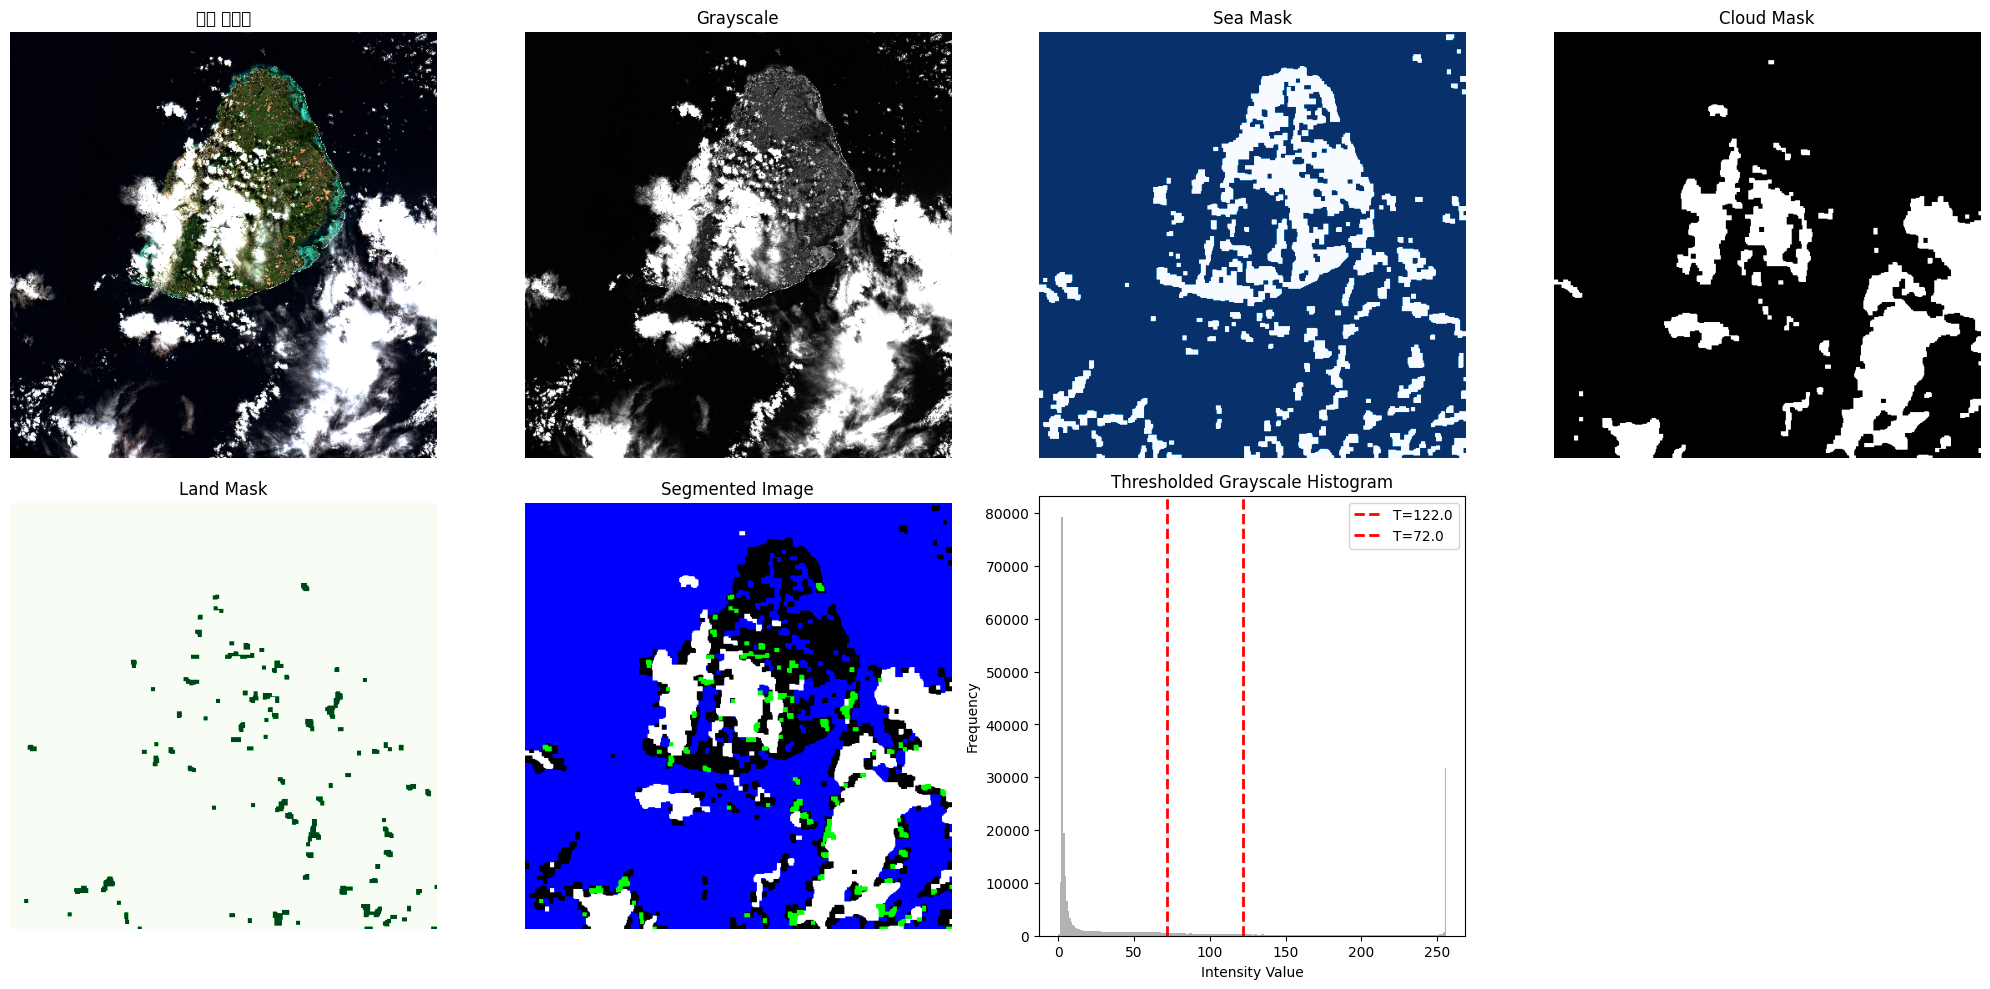

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def otsu_thresholding(gray_image):
    """
    Otsu의 이진화를 적용하여 임계값과 이진 마스크를 반환하는 함수.
    
    Parameters:
    - gray_image: 그레이스케일 이미지 (2D numpy 배열).
    
    Returns:
    - threshold: Otsu의 임계값.
    - binary_mask: 이진화된 마스크.
    """
    threshold, binary_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return threshold, binary_mask

def apply_morphology(mask, kernel_size=5):
    """
    마스크에 형태학적 연산을 적용하여 노이즈를 제거하는 함수.
    
    Parameters:
    - mask: 이진 마스크 (2D numpy 배열).
    - kernel_size: 구조 요소의 크기.
    
    Returns:
    - refined_mask: 정제된 이진 마스크.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def get_masks_otsu(gray_image, thresholds):
    """
    Otsu의 임계값을 기반으로 바다, 육지, 구름 마스크를 생성하는 함수.
    
    Parameters:
    - gray_image: 그레이스케일 이미지 (2D numpy 배열).
    - thresholds: 임계값 리스트.
    
    Returns:
    - sea_mask: 바다 마스크 (이진 이미지).
    - land_mask: 육지 마스크 (이진 이미지).
    - cloud_mask: 구름 마스크 (이진 이미지).
    """
    if len(thresholds) != 2:
        raise ValueError("세 개의 클래스를 위해 정확히 두 개의 임계값이 필요합니다.")
    
    T1, T2 = thresholds
    
    # 바다 마스크: T1 이하
    _, sea_mask = cv2.threshold(gray_image, T1, 255, cv2.THRESH_BINARY_INV)
    
    # 구름 마스크: T2 이상
    _, cloud_mask = cv2.threshold(gray_image, T2, 255, cv2.THRESH_BINARY)
    
    # 육지 마스크: T1과 T2 사이
    land_mask = cv2.inRange(gray_image, T1 + 1, T2 - 1)
    
    return sea_mask, land_mask, cloud_mask

def create_segmented_image(img, sea_mask, land_mask, cloud_mask):
    """
    바다, 육지, 구름에 대해 다른 색상을 적용한 세그멘테이션 이미지를 생성하는 함수.
    
    Parameters:
    - img: 원본 BGR 이미지 (3D numpy 배열).
    - sea_mask: 바다 마스크 (이진 이미지).
    - land_mask: 육지 마스크 (이진 이미지).
    - cloud_mask: 구름 마스크 (이진 이미지).
    
    Returns:
    - segmented_image: 색상으로 구분된 세그멘테이션 이미지.
    """
    segmented_image = np.zeros_like(img)
    
    # 색상 정의 (BGR)
    sea_color = [255, 0, 0]        # 파란색
    land_color = [0, 255, 0]       # 초록색
    cloud_color = [255, 255, 255]  # 흰색
    
    # 마스크 기반으로 색상 적용
    segmented_image[sea_mask == 255] = sea_color
    segmented_image[land_mask == 255] = land_color
    segmented_image[cloud_mask == 255] = cloud_color
    
    return segmented_image

def visualize_masks(img, gray, sea_mask, land_mask, cloud_mask, segmented_image, thresholds):
    """
    원본 이미지, 그레이스케일 이미지, 마스크, 세그멘테이션 이미지를 시각화하는 함수.
    
    Parameters:
    - img: 원본 BGR 이미지 (3D numpy 배열).
    - gray: 그레이스케일 이미지 (2D numpy 배열).
    - sea_mask: 바다 마스크 (이진 이미지).
    - land_mask: 육지 마스크 (이진 이미지).
    - cloud_mask: 구름 마스크 (이진 이미지).
    - segmented_image: 색상으로 구분된 세그멘테이션 이미지.
    - thresholds: 임계값 리스트.
    """
    plt.figure(figsize=(20, 10))
    
    plt.subplot(2, 4, 1)
    plt.title("원본 이미지")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.title("Grayscale")
    plt.imshow(gray, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 4, 3)
    plt.title("Sea Mask")
    plt.imshow(sea_mask, cmap='Blues')
    plt.axis('off')
    
    plt.subplot(2, 4, 4)
    plt.title("Cloud Mask")
    plt.imshow(cloud_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 4, 5)
    plt.title("Land Mask")
    plt.imshow(land_mask, cmap='Greens')
    plt.axis('off')
    
    plt.subplot(2, 4, 6)
    plt.title("Segmented Image")
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    # 그레이스케일 히스토그램과 임계값 표시
    plt.subplot(2, 4, 7)
    plt.title("Thresholded Grayscale Histogram")
    plt.hist(gray.ravel(), bins=256, range=(0, 256), color='gray', alpha=0.6)
    for T in thresholds:
        plt.axvline(T, color='r', linestyle='dashed', linewidth=2, label=f'T={T}')
    plt.xlabel("Intensity Value")
    plt.ylabel("Frequency")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
# Step 1: 이미지 읽기 및 전처리
img = cv2.imread('./tasksample.png')  # 이미지 경로를 실제 이미지 파일로 변경하세요.
img = cv2.resize(img, (512, 512))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 2: 구름 분리를 위한 Otsu의 이진화 적용
T_cloud, cloud_mask = otsu_thresholding(gray)
print(f"구름 임계값 (T_cloud): {T_cloud}")

# Step 3: 구름 마스크 정제
cloud_mask = apply_morphology(cloud_mask)

# Step 4: 구름을 제외한 그레이스케일 이미지 생성
gray_no_cloud = cv2.bitwise_and(gray, gray, mask=cv2.bitwise_not(cloud_mask))

# Step 5: 바다와 육지를 분리하기 위한 Otsu의 이진화 적용
T_sea_land, sea_land_mask = otsu_thresholding(gray_no_cloud)
print(f"바다와 육지 임계값 (T_sea_land): {T_sea_land}")

# Step 6: 바다와 육지 마스크 생성
# 바다 마스크: T_sea_land 이하
_, sea_mask = cv2.threshold(gray_no_cloud, T_sea_land, 255, cv2.THRESH_BINARY_INV)

# 육지 마스크: T_sea_land 이상
_, land_mask = cv2.threshold(gray_no_cloud, T_sea_land, 255, cv2.THRESH_BINARY)

# Step 7: 바다와 육지 마스크 정제
sea_mask = apply_morphology(sea_mask)
land_mask = apply_morphology(land_mask)

# Step 8: 세그멘테이션 이미지 생성
segmented_image = create_segmented_image(img, sea_mask, land_mask, cloud_mask)

# Step 9: 결과 시각화
visualize_masks(img, gray, sea_mask, land_mask, cloud_mask, segmented_image, [T_cloud, T_sea_land])

# 시각화

시각화 중: augments1.png 및 augments1.txt


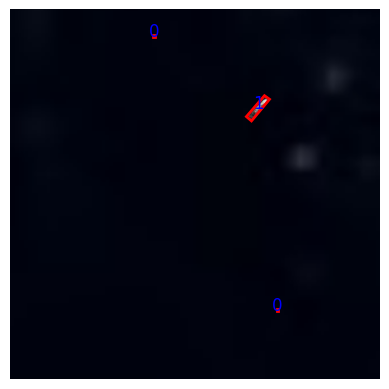

시각화 중: augments10.png 및 augments10.txt


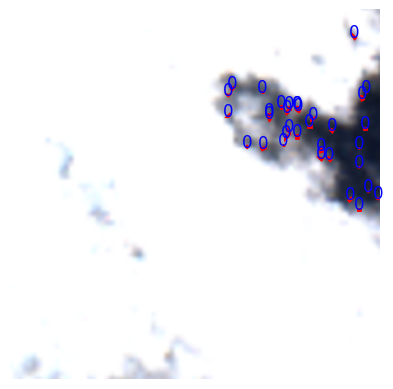

시각화 중: augments2.png 및 augments2.txt


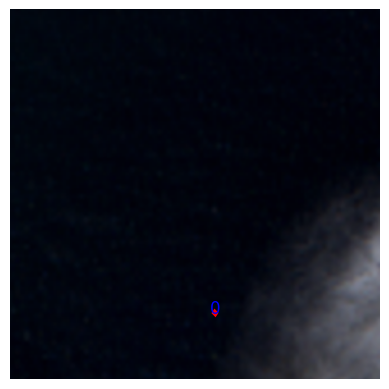

시각화 중: augments3.png 및 augments3.txt


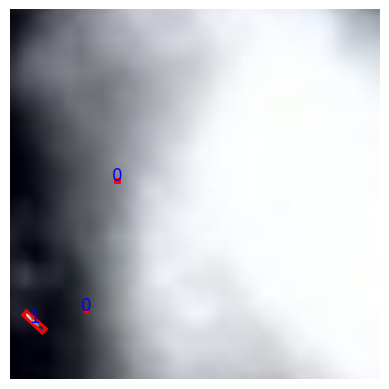

시각화 중: augments4.png 및 augments4.txt


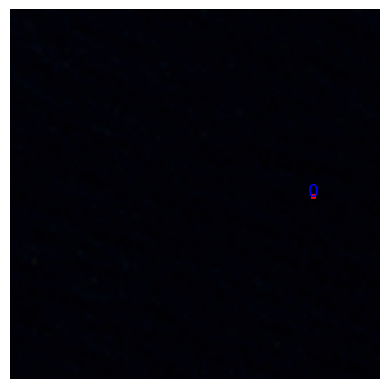

시각화 중: augments5.png 및 augments5.txt


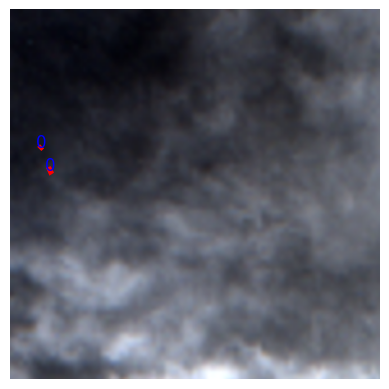

시각화 중: augments6.png 및 augments6.txt


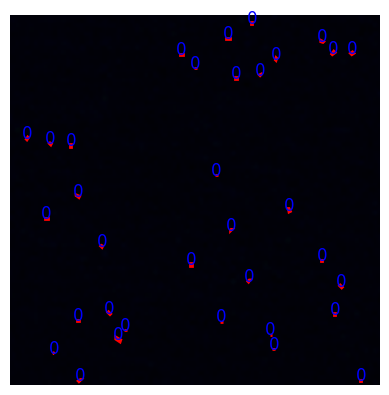

시각화 중: augments7.png 및 augments7.txt


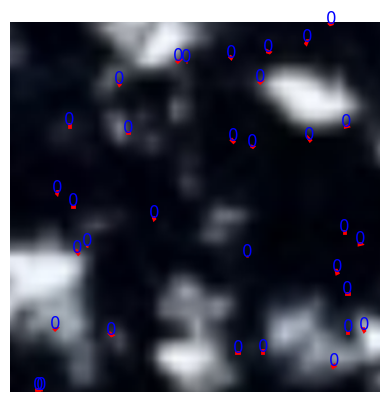

시각화 중: augments8.png 및 augments8.txt


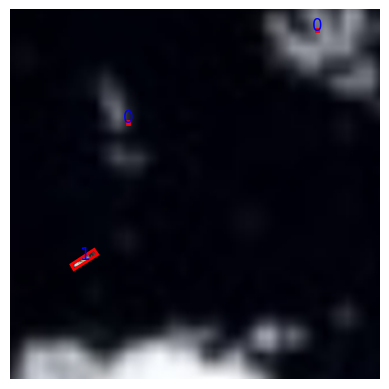

시각화 중: augments9.png 및 augments9.txt


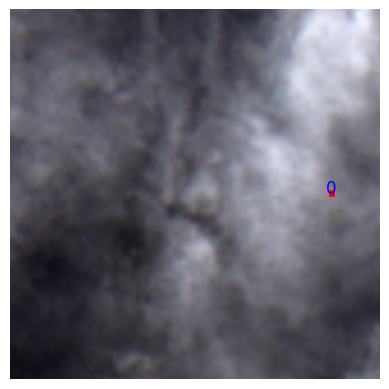

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_image_with_coords(image_path, coords_list):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for class_name, coords in coords_list:
        # coords: [x1, y1, x2, y2, x3, y3, x4, y4]
        coords = np.array(coords)
        coords = coords.reshape(4, 2)  # 4개의 좌표쌍 (x, y)으로 변환

        # 다각형 그리기 (4개의 좌표를 사용한 회전된 바운딩 박스)
        polygon = patches.Polygon(coords, closed=True, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(polygon)

        # 클래스 이름 표시 (옵션)
        cx, cy = np.mean(coords[:, 0]), np.mean(coords[:, 1])  # 중심 좌표
        ax.text(cx, cy, class_name, color='blue', fontsize=12, ha='center')

    plt.axis('off')
    plt.show()

def visualize_labels_on_image(image_path, label_path):
    img = Image.open(image_path)
    img_w, img_h = img.size

    coords_list = []
    with open(label_path, 'r') as f:
        label_lines = f.readlines()

    for label_line in label_lines:
        label_split = label_line.strip().split()
        if len(label_split) != 9:
            print(f"잘못된 라벨 형식: {label_line}")
            continue
        class_label = label_split[0]
        coords = list(map(float, label_split[1:]))

        # 상대 좌표를 절대 좌표로 변환
        abs_coords = []
        for i in range(0, len(coords), 2):
            x_rel = coords[i]
            y_rel = coords[i+1]
            x_abs = x_rel * img_w
            y_abs = y_rel * img_h
            abs_coords.extend([x_abs, y_abs])

        coords_list.append((class_label, abs_coords))

    # 변환된 좌표를 사용하여 시각화 함수 호출
    visualize_image_with_coords(image_path, coords_list)

# 사용 예시
image_dir = "./dataset3/images/"
label_dir = "./dataset3/labels/"

# 디렉토리 내의 파일들을 가져옵니다.
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])

# 이미지와 라벨을 하나씩 시각화합니다.
for image_file, label_file in zip(image_files, label_files):
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, label_file)
    print(f"시각화 중: {image_file} 및 {label_file}")
    visualize_labels_on_image(image_path, label_path)